<p style="background-color:#009de1;font-family:tahoma;font-size:30pt;color:white;text-align:center;border-radius:10px; padding-bottom:2.5%; height:70px; line-height:70px;"><b>Loan Interest Rate Prediction  </b></p>

# Project: Interest Rate Prediction Based on Loan Applicant Information

## 1. Problem Understanding

We aim to predict the interest rate category (1/2/3) for a loan application based on client-related information. The goal is to:

1. Help consumers understand factors affecting their loan rates to improve creditworthiness.
2. Assist lenders with accurate, immediate interest rate category estimations

In [1]:
#Importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

# To ignores the warnings
import warnings
warnings.filterwarnings('ignore')

C:\Users\giova\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

from sklearn.feature_selection import RFE
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import GridSearchCV,StratifiedKFold,cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier, XGBRFClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier



In [3]:
#Reading datasets
#test dataset
dftest = pd.read_csv('C:/Users/giova/Documents/gio trf/Loan Interest Rate v2/test.csv')
#train dataset
df = pd.read_csv('C:/Users/giova/Documents/gio trf/Loan Interest Rate v2/train.csv')

In [4]:
df.head(10)

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1
5,10000006,"4,500",2 years,Rent,30000.0,VERIFIED - income source,credit_card,10.88,1,NaN,12,15,Male,3
6,10000007,"18,075",4 years,Rent,85000.0,VERIFIED - income,debt_consolidation,5.65,0,NaN,9,12,Male,3
7,10000008,"15,000",< 1 year,Rent,115000.0,VERIFIED - income,debt_consolidation,7.97,1,16.0,25,31,Female,2
8,10000009,"6,300",10+ years,Rent,NaN,not verified,debt_consolidation,16.12,3,NaN,8,9,Female,3
9,10000010,"30,000",10+ years,Own,163000.0,VERIFIED - income,debt_consolidation,11.13,0,NaN,24,43,Male,1


The dataset contains the following key features:

1. Loan-related information: Loan_Amount_Requested, Purpose_Of_Loan, Debt_To_Income, etc.
2. Applicant details: Length_Employed, Home_Owner, Annual_Income, Income_Verified, etc.
3. Target variable: Interest_Rate (categories 1, 2, 3)

In [5]:
df = df.drop(['Loan_ID'], axis=1)

## 2. Data Understanding

In [6]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Loan_Amount_Requested,object,0,0.00,1290,"[13,250, 23,225]"
1,Length_Employed,object,7371,4.49,11,"[9 years, 4 years]"
2,Home_Owner,object,25359,15.43,4,"[Other, nan]"
3,Annual_Income,float64,25102,15.28,12305,"[840000.0, 63200.0]"
4,Income_Verified,object,0,0.00,3,"[VERIFIED - income, not verified]"
5,Purpose_Of_Loan,object,0,0.00,14,"[moving, medical]"
6,Debt_To_Income,float64,0,0.00,3953,"[13.34, 21.77]"
7,Inquiries_Last_6Mo,int64,0,0.00,9,"[3, 6]"
8,Months_Since_Deliquency,float64,88379,53.79,122,"[129.0, 94.0]"
9,Number_Open_Accounts,int64,0,0.00,58,"[8, 1]"


In [7]:
zero_accounts = df[(df['Number_Open_Accounts'] == 0) | (df['Total_Accounts'] == 0)]
print(zero_accounts)

      Loan_Amount_Requested Length_Employed Home_Owner  Annual_Income  \
8867                 16,000         9 years       Rent            NaN   
72538                 3,550          1 year        Own        43680.0   

         Income_Verified     Purpose_Of_Loan  Debt_To_Income  \
8867   VERIFIED - income                 car             0.0   
72538  VERIFIED - income  debt_consolidation             0.0   

       Inquiries_Last_6Mo  Months_Since_Deliquency  Number_Open_Accounts  \
8867                    0                      NaN                     0   
72538                   0                      NaN                     0   

       Total_Accounts  Gender  Interest_Rate  
8867               19  Female              3  
72538               3    Male              3  


In [8]:
import missingno

<Axes: >

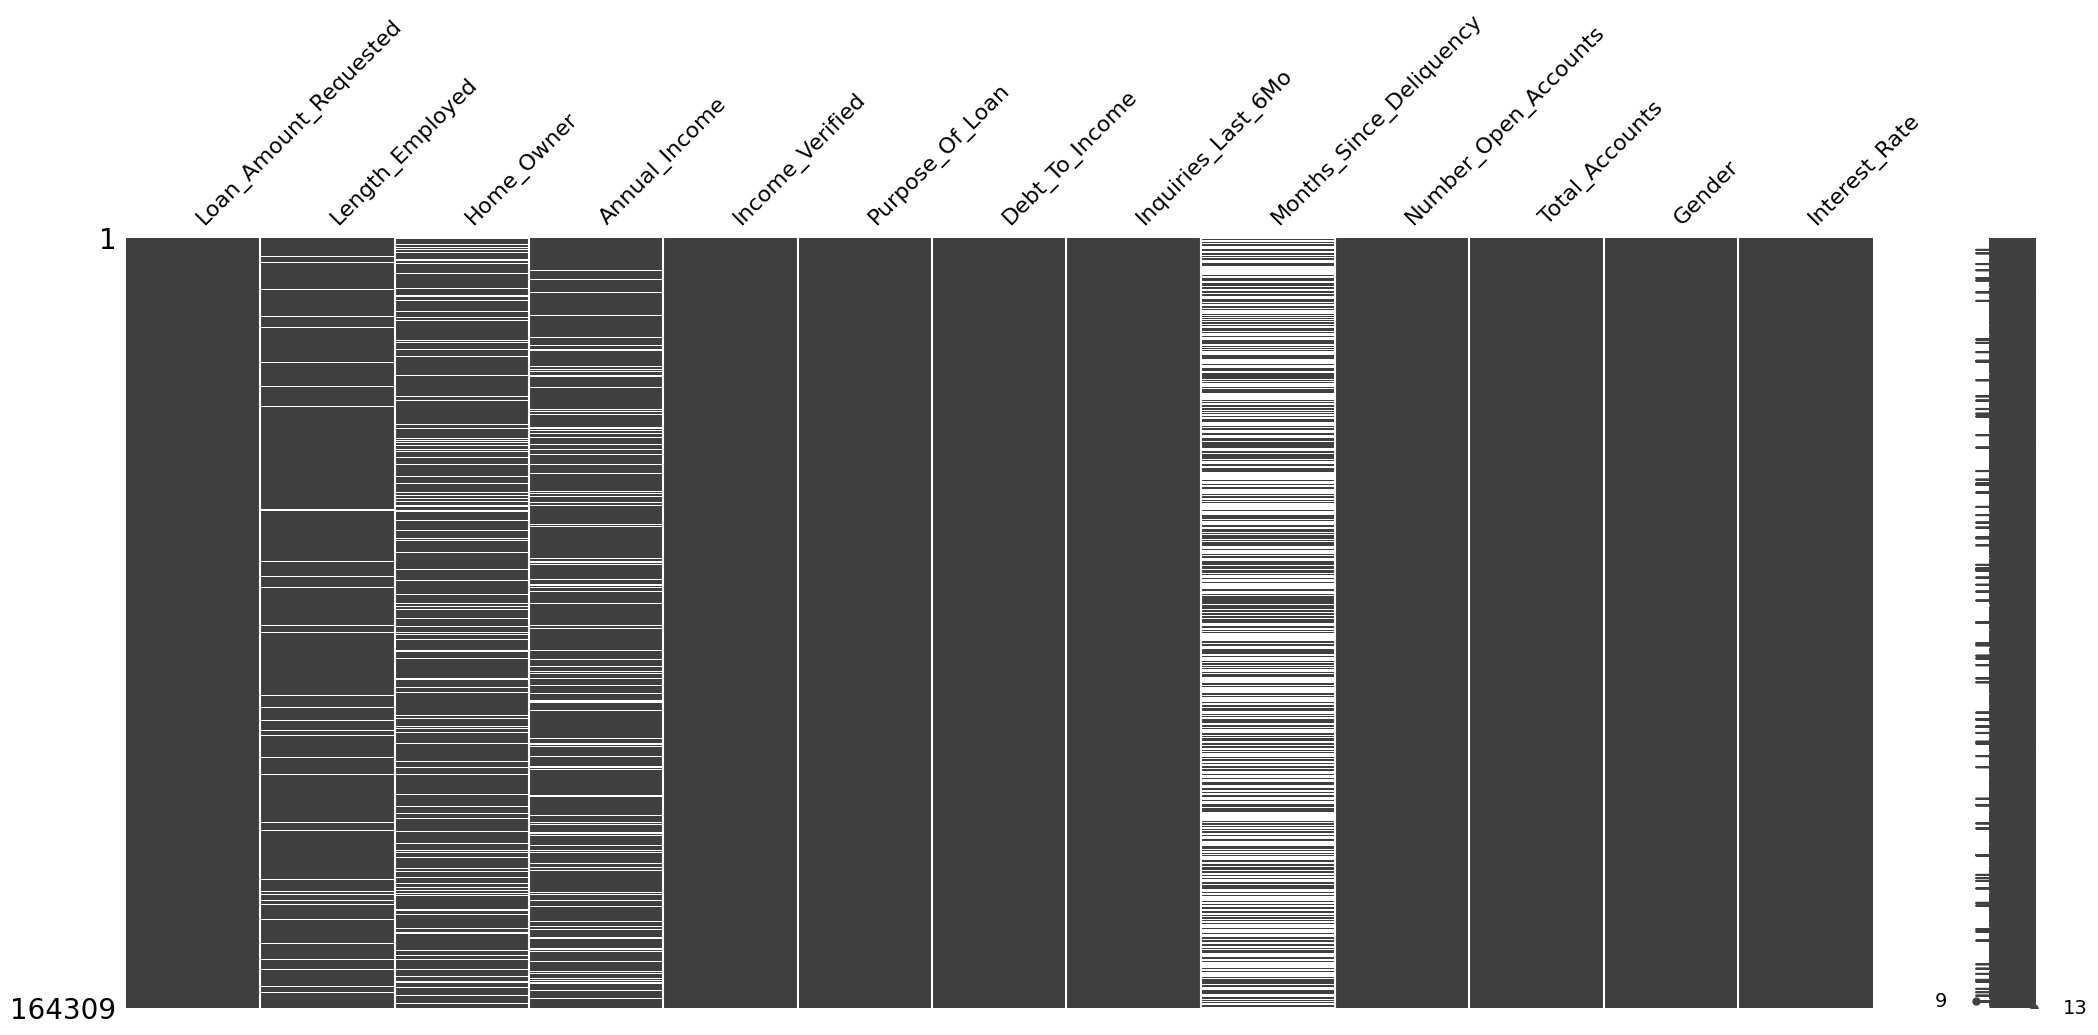

In [9]:
missingno.matrix(df)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164309 entries, 0 to 164308
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Loan_Amount_Requested    164309 non-null  object 
 1   Length_Employed          156938 non-null  object 
 2   Home_Owner               138950 non-null  object 
 3   Annual_Income            139207 non-null  float64
 4   Income_Verified          164309 non-null  object 
 5   Purpose_Of_Loan          164309 non-null  object 
 6   Debt_To_Income           164309 non-null  float64
 7   Inquiries_Last_6Mo       164309 non-null  int64  
 8   Months_Since_Deliquency  75930 non-null   float64
 9   Number_Open_Accounts     164309 non-null  int64  
 10  Total_Accounts           164309 non-null  int64  
 11  Gender                   164309 non-null  object 
 12  Interest_Rate            164309 non-null  int64  
dtypes: float64(3), int64(4), object(6)
memory usage: 16.3+ MB


There is a significant amount of missing data (NA) in the dataset, particularly in the Months_Since_Delinquency feature. However, we cannot discard all of it because there is an assumption that the missing values in this feature occur due to individuals who have never experienced any late payments.

In [11]:
df['Months_Since_Deliquency'].fillna(999, inplace=True)

In [12]:
# median_income = df['Annual_Income'].median()
# df['Annual_Income'].fillna(median_income, inplace=True)
df=df.dropna()

In [13]:
# Delete rows where Number_Open_Accounts or Total_Accounts is 0
df = df[(df['Number_Open_Accounts'] != 0) & (df['Total_Accounts'] != 0)]

I remove rows where Number_Open_Accounts or Total_Accounts is 0 because such rows likely indicate cases with no active or total accounts. Keeping them in the dataset might introduce noise or bias, as these records do not contribute meaningful information to the analysis. By excluding them, I can focus on relevant data, ensuring that the analysis reflects more accurate and actionable insights.

In [14]:
#Remove , in Loan Amount Requested
def removecar(x):
    x=x.replace(',','')
    return x

df['Loan_Amount_Requested']=df['Loan_Amount_Requested'].apply(removecar).astype(float)

In [15]:
# Convert 'Length_Employed' to numeric
length_map = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
              '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}
df['Length_Employed'] = df['Length_Employed'].map(length_map).astype(float)

In [16]:
df['Length_Employed'] = df['Length_Employed'].fillna(0)

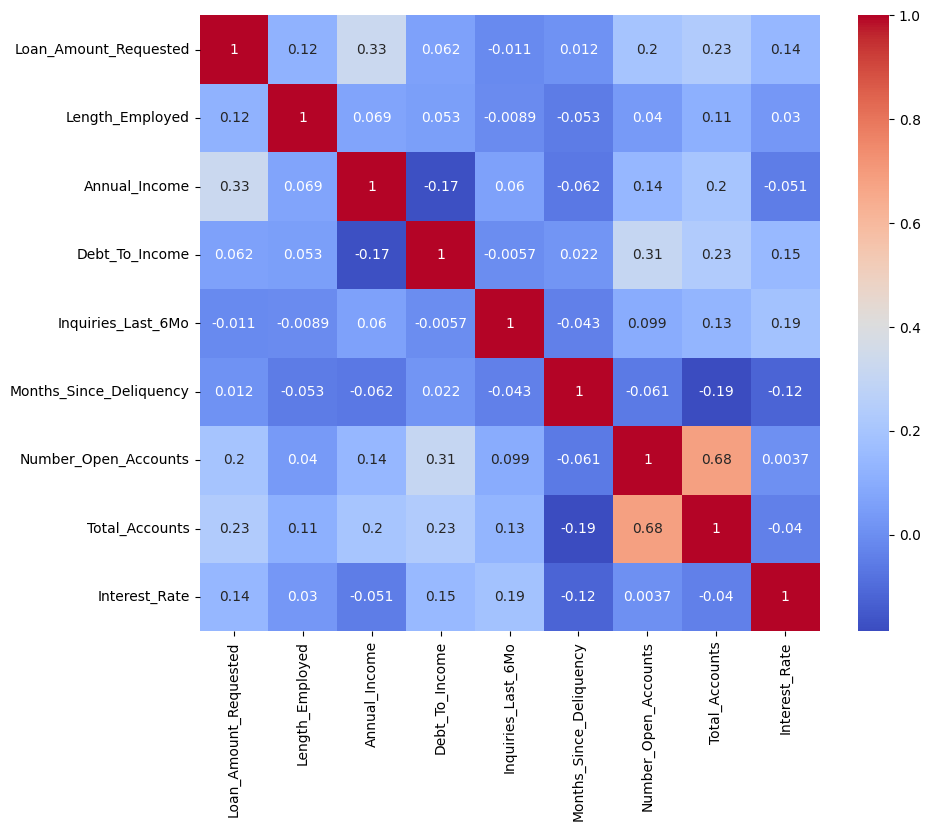

In [17]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Create a heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2g', cmap='coolwarm')

plt.show()

In [18]:
def group_cols_by_dtype(df):
    num_cols, cat_cols, dt_cols, bool_cols = [], [], [], []
    
    num_cols.append(df.select_dtypes(include=['int', 'float']).columns.to_list())
    cat_cols.append(df.select_dtypes(include=['object', 'category']).columns.to_list())
    dt_cols.append(df.select_dtypes(include=['datetime']).columns.to_list())
    bool_cols.append(df.select_dtypes(include=['bool']).columns.to_list())
    
    return num_cols, cat_cols, dt_cols, bool_cols

In [19]:
num_cols, cat_cols, dt_cols, bool_cols = group_cols_by_dtype(df)

In [20]:
num_cols

[['Loan_Amount_Requested',
  'Length_Employed',
  'Annual_Income',
  'Debt_To_Income',
  'Inquiries_Last_6Mo',
  'Months_Since_Deliquency',
  'Number_Open_Accounts',
  'Total_Accounts',
  'Interest_Rate']]

In [21]:
cat_cols

[['Home_Owner', 'Income_Verified', 'Purpose_Of_Loan', 'Gender']]

In [22]:
df['Interest_Rate'].value_counts()

Interest_Rate
2    48443
3    40806
1    23251
Name: count, dtype: int64

In [23]:
def histogram_num_features(df):
    print("Histogram for Numerical Features")
    df[num_cols[0][:-1]].hist(figsize = (20,10), bins=50);
    plt.show();

In [24]:
def boxplot_num_features(df):
    print("Box Plot for Numerical Features")
    for col in num_cols[0][:-1]:
        df[col].plot(kind = 'box');
        plt.show();

Histogram for Numerical Features


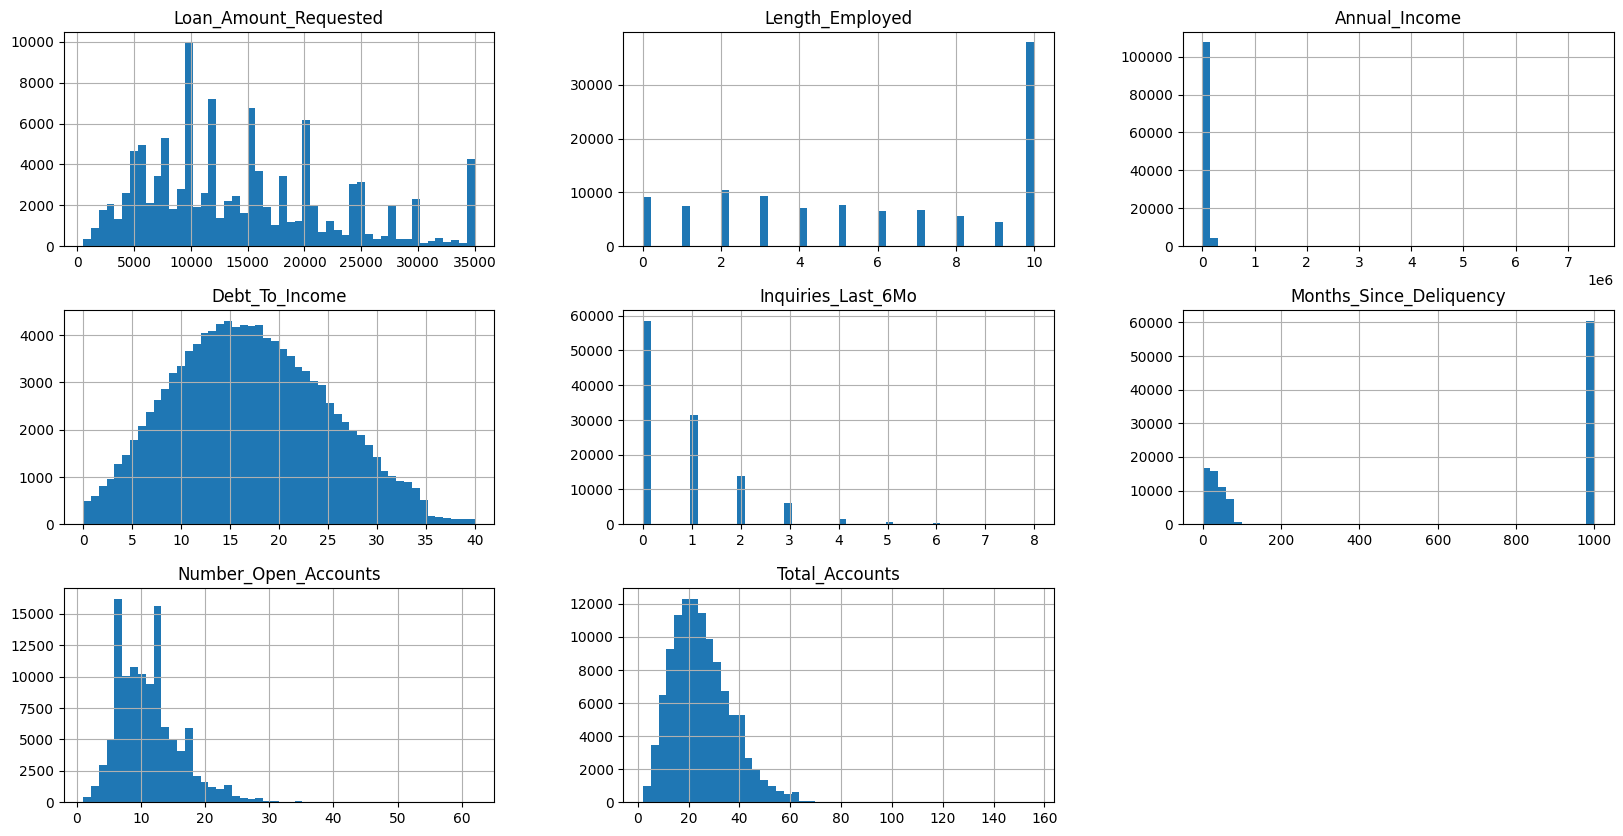

In [25]:
histogram_num_features(df)

Box Plot for Numerical Features


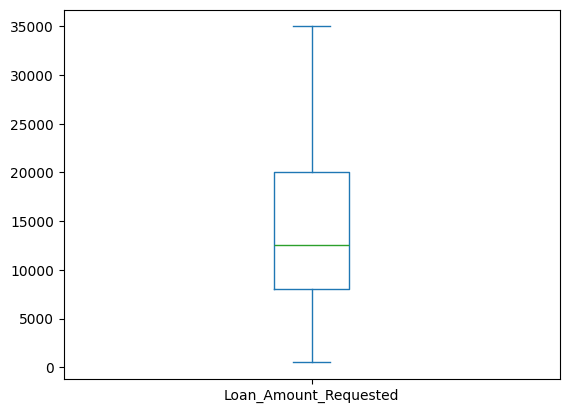

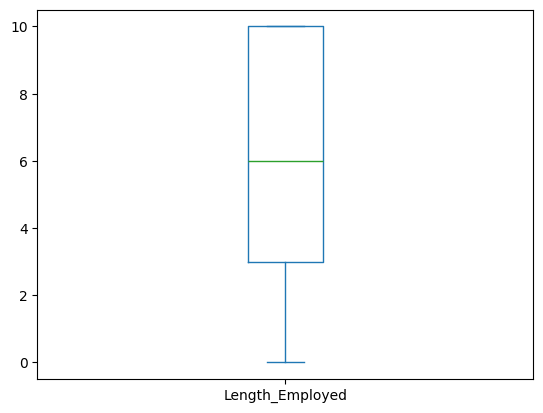

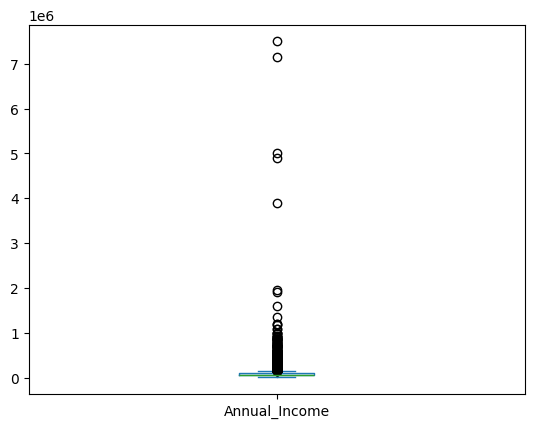

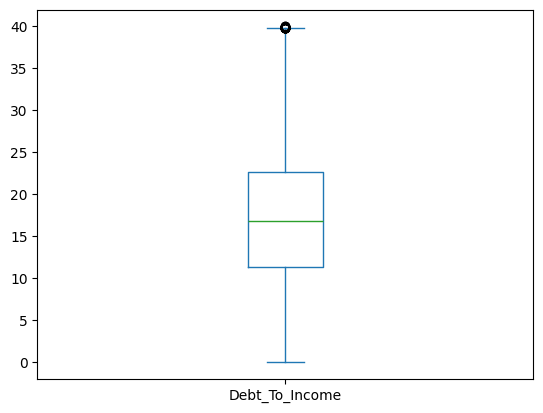

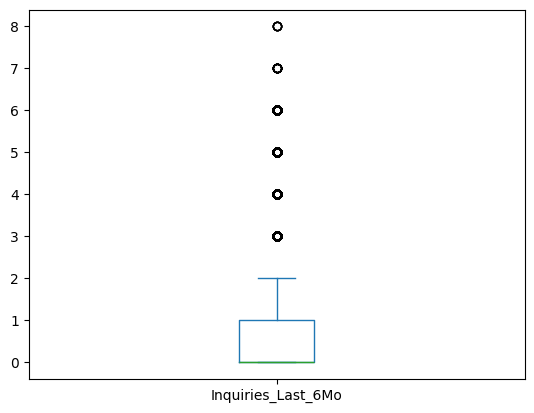

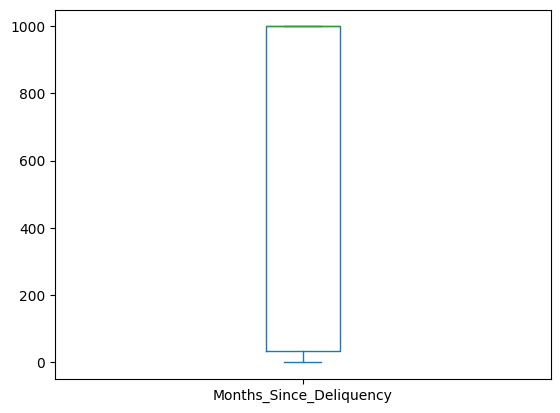

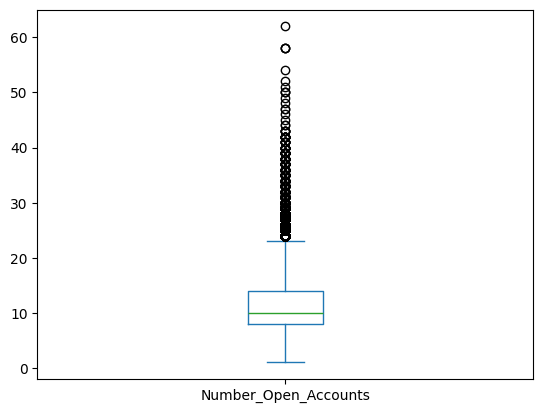

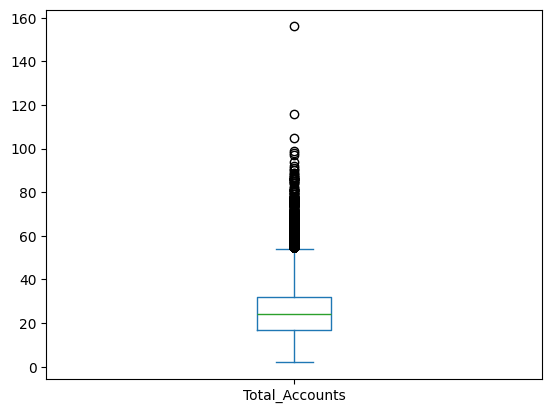

In [26]:
boxplot_num_features(df);

It is evident that there are many outliers in the dataset. To address this, I will clean the data using the Interquartile Range (IQR) method. This method helps identify and remove data points that fall significantly outside the normal range, improving the dataset's quality and making it more suitable for analysis.

In [27]:
def find_anomalies(data):
    # Calculate the first and third quartiles
    q1 = np.percentile(data, 25)  # 25th percentile (Q1)
    q3 = np.percentile(data, 75)  # 75th percentile (Q3)
    
    # Calculate the interquartile range (IQR)
    iqr = q3 - q1
    print(f"IQR (Interquartile Range): {iqr:.2f}")
    
    # Determine the lower and upper bounds
    lower_limit = q1 - 1.5 * iqr
    upper_limit = q3 + 1.5 * iqr
    print(f"Lower Limit: {lower_limit:.2f}")
    print(f"Upper Limit: {upper_limit:.2f}")
    
    # Identify outliers
    outliers = data[(data < lower_limit) | (data > upper_limit)]
    print(f"Number of Outliers: {len(outliers)}")
    
    return outliers

In [28]:
list_outlier = ['Annual_Income','Debt_To_Income','Total_Accounts','Number_Open_Accounts','Inquiries_Last_6Mo']
for i in list_outlier:
    print('Feature:',i)
    find_anomalies(df[i])
    print('=======================')

Feature: Annual_Income
IQR (Interquartile Range): 44000.00
Lower Limit: -20000.00
Upper Limit: 156000.00
Number of Outliers: 4706
Feature: Debt_To_Income
IQR (Interquartile Range): 11.37
Lower Limit: -5.74
Upper Limit: 39.73
Number of Outliers: 33
Feature: Total_Accounts
IQR (Interquartile Range): 15.00
Lower Limit: -5.50
Upper Limit: 54.50
Number of Outliers: 2142
Feature: Number_Open_Accounts
IQR (Interquartile Range): 6.00
Lower Limit: -1.00
Upper Limit: 23.00
Number of Outliers: 2629
Feature: Inquiries_Last_6Mo
IQR (Interquartile Range): 1.00
Lower Limit: -1.50
Upper Limit: 2.50
Number of Outliers: 8431


In [29]:
# Filtering Data
df = df[(df['Annual_Income'] <= 156000.0)]

df = df[(df['Debt_To_Income'] <= 39.735)]

df = df[(df['Total_Accounts'] <= 54.5)]

df = df[(df['Number_Open_Accounts'] <= 23.0)]

df = df[(df['Inquiries_Last_6Mo'] <= 2.5)]

The following step is to analyze the distribution of each numerical feature, I will check the density of the data using density plots (e.g., Kernel Density Estimation, or KDE). This will allow me to understand how the values are distributed (e.g., normal, skewed, or multimodal) and identify potential issues like skewness, outliers, or irregular patterns that might affect the analysis.

In [30]:
def numerical_features_with_target(data, col):
    data[data['Interest_Rate'] == 1][col].plot(kind='density', label='Interest Rate 1')
    data[data['Interest_Rate'] == 2][col].plot(kind='density', label='Interest Rate 2')
    data[data['Interest_Rate'] == 3][col].plot(kind='density', label='Interest Rate 3')
    
    plt.xlabel(col)
    plt.title(f'Density Plot of {col} by Interest Rate')
    plt.legend()
    plt.show()

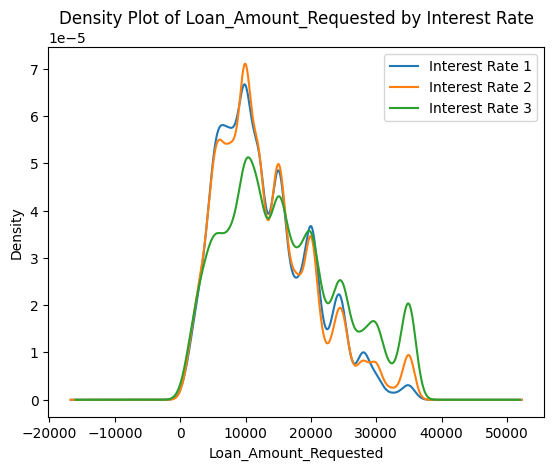

In [31]:
numerical_features_with_target(df, 'Loan_Amount_Requested')

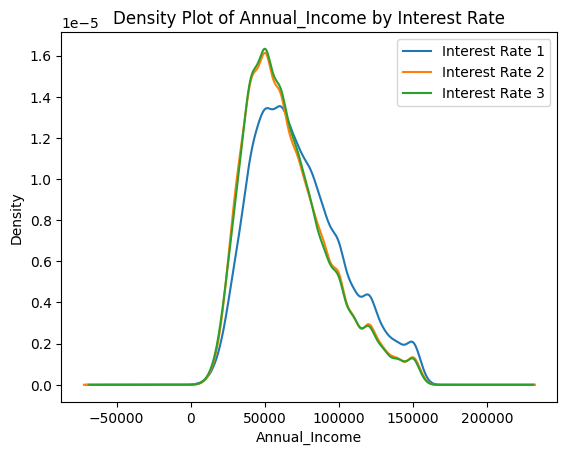

In [32]:
numerical_features_with_target(df, 'Annual_Income')

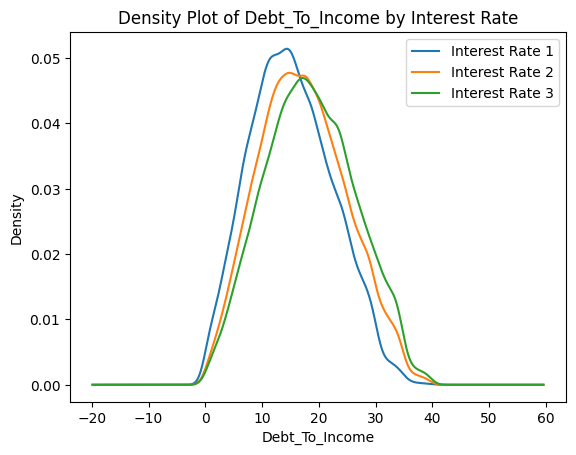

In [33]:
numerical_features_with_target(df, 'Debt_To_Income')

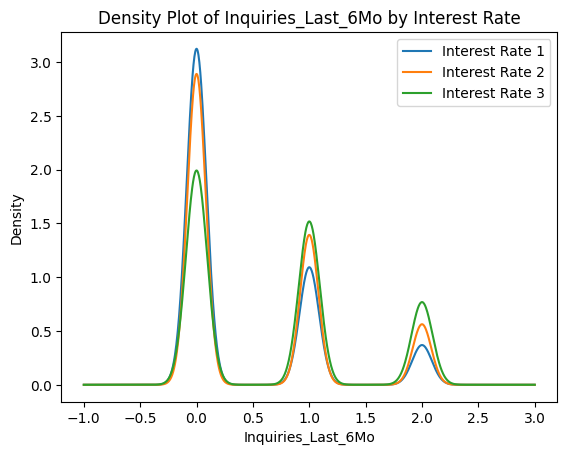

In [34]:
numerical_features_with_target(df, 'Inquiries_Last_6Mo')

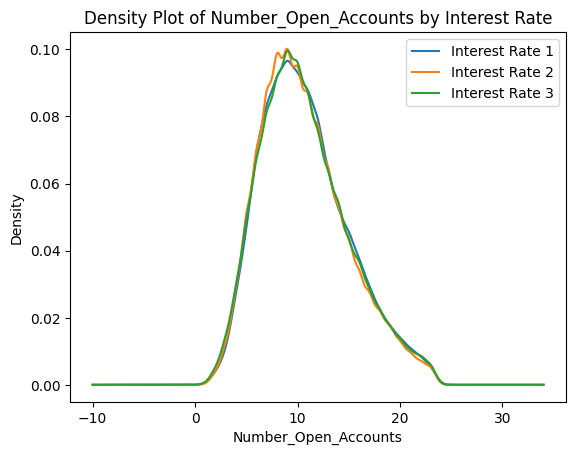

In [35]:
numerical_features_with_target(df, 'Number_Open_Accounts')

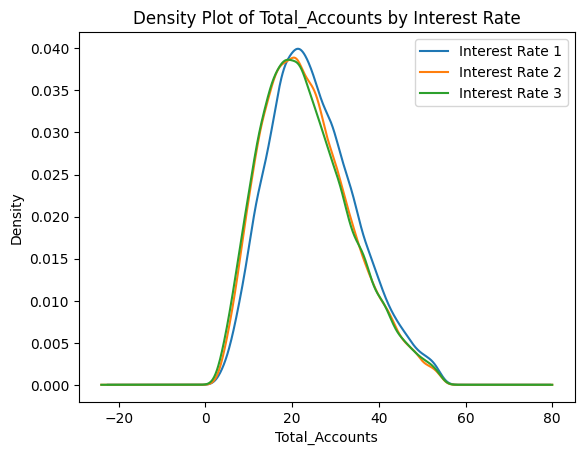

In [36]:
numerical_features_with_target(df, 'Total_Accounts')

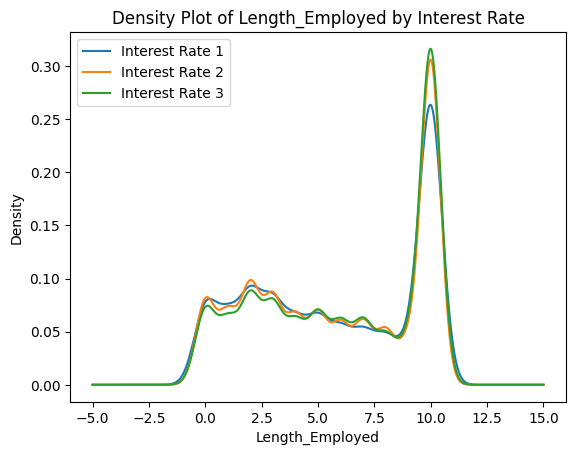

In [37]:
numerical_features_with_target(df, 'Length_Employed')

In [38]:
# find distribution of categorical feature
for col in cat_cols[0]:
    print("Distribution of", col)
    display(pd.DataFrame(df[col].value_counts()))

Distribution of Home_Owner


,count
Home_Owner,
Mortgage,47408
Rent,40999
Own,8375
Other,34


Distribution of Income_Verified


,count
Income_Verified,
not verified,33510
VERIFIED - income,31695
VERIFIED - income source,31611


Distribution of Purpose_Of_Loan


,count
Purpose_Of_Loan,
debt_consolidation,57826
credit_card,21778
home_improvement,4976
other,4809
major_purchase,2005
small_business,1293
car,1109
medical,897
moving,559


Distribution of Gender


,count
Gender,
Male,69023
Female,27793


<Axes: xlabel='Interest_Rate', ylabel='count'>

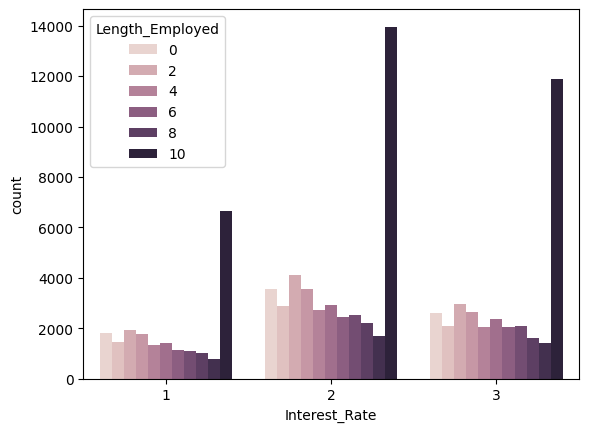

In [39]:
sns.countplot(x='Interest_Rate', hue='Length_Employed',data=df)

In [40]:
unique_purposes = df['Purpose_Of_Loan'].unique()
print(unique_purposes)

['car' 'debt_consolidation' 'credit_card' 'home_improvement'
 'major_purchase' 'medical' 'small_business' 'other' 'educational'
 'wedding' 'moving' 'vacation' 'house' 'renewable_energy']


In [41]:
purpose_map = {
    'debt_consolidation': 'Debt',
    'credit_card': 'Debt',
    'home_improvement': 'Home',
    'medical': 'Health',
    'education': 'Education',
    'small_business': 'Business',
    'car': 'Personal',
    'vacation': 'Leisure',
    'wedding': 'Personal',
    'major_purchase': 'Personal',
    'house': 'Home',
    'moving': 'Home',
    'renewable_energy': 'Home',
    'other': 'Other',
    'none': 'Other'
}

# Menyederhanakan kategori Purpose_Of_Loan
df['Simplified_Purpose'] = df['Purpose_Of_Loan'].map(purpose_map).fillna('Other')


# Melihat distribusi kategori baru
print(df['Simplified_Purpose'].value_counts())

Simplified_Purpose
Debt        79604
Home         6009
Other        4892
Personal     3626
Business     1293
Health        897
Leisure       495
Name: count, dtype: int64


<Axes: xlabel='Interest_Rate', ylabel='count'>

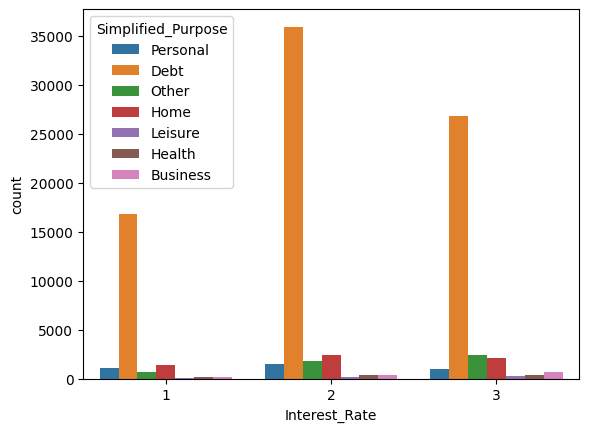

In [42]:
sns.countplot(x='Interest_Rate', hue='Simplified_Purpose',data=df)

In [43]:
df['Is_Home_Owner'] = df['Home_Owner'].apply(lambda x: 1 if x in ['Own', 'Mortgage'] else 0)

<Axes: xlabel='Interest_Rate', ylabel='count'>

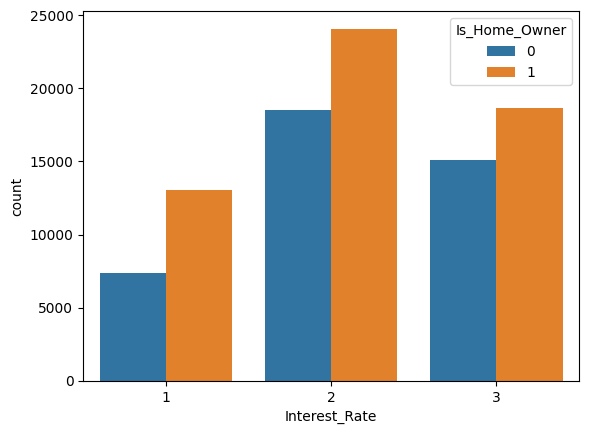

In [44]:
sns.countplot(x='Interest_Rate', hue='Is_Home_Owner',data=df)

In [45]:
df['Is_Income_Verified'] = df['Income_Verified'].apply(lambda x: 1 if x == 'VERIFIED - income' else 0)

<Axes: xlabel='Interest_Rate', ylabel='count'>

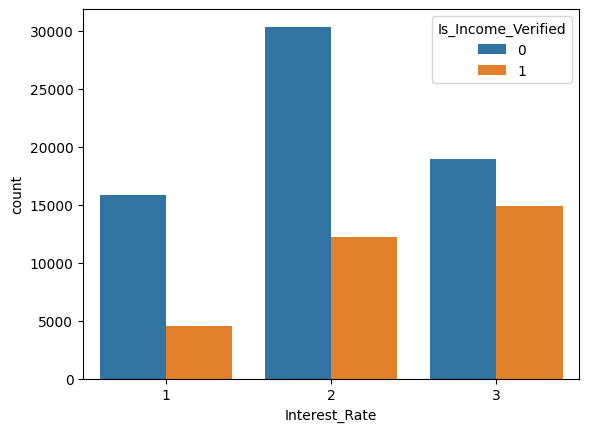

In [46]:
sns.countplot(x='Interest_Rate', hue='Is_Income_Verified',data=df)

### Feature Engineering

In [47]:
df['Debt_To_Income_per_Account'] = df['Debt_To_Income'] / (df['Number_Open_Accounts'])

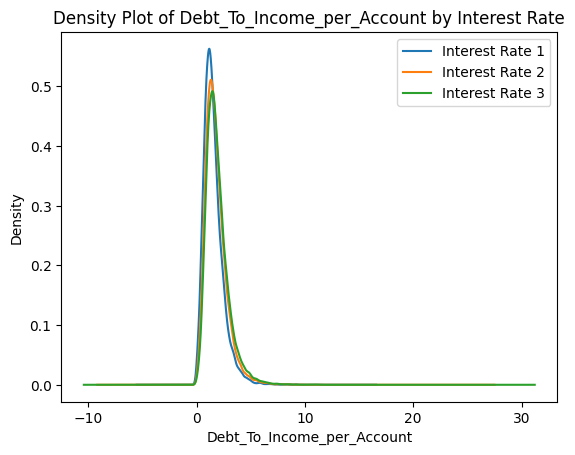

In [48]:
numerical_features_with_target(df, 'Debt_To_Income_per_Account')

In [49]:
df['Income_to_Loan_Ratio'] = df['Annual_Income'] / (df['Loan_Amount_Requested'])

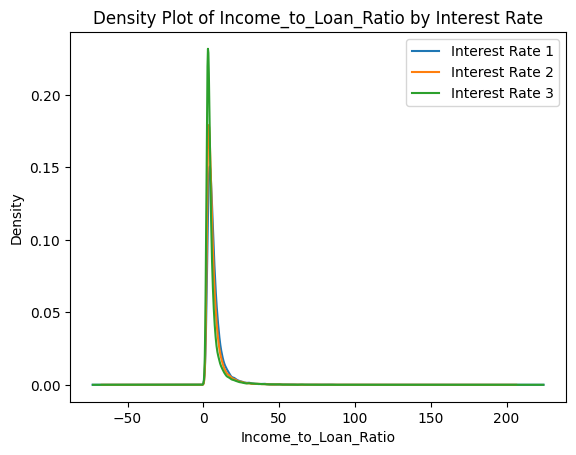

In [50]:
numerical_features_with_target(df, 'Income_to_Loan_Ratio')

In [51]:
df['Credit_Utilization'] = df['Number_Open_Accounts'] / (df['Total_Accounts'])

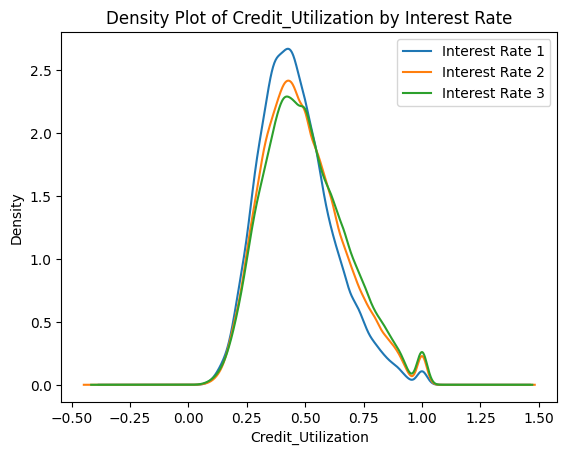

In [52]:
numerical_features_with_target(df, 'Credit_Utilization')

In [53]:
df['Loan_Request_per_Total_Accounts'] = df['Loan_Amount_Requested'] / (df['Total_Accounts'])

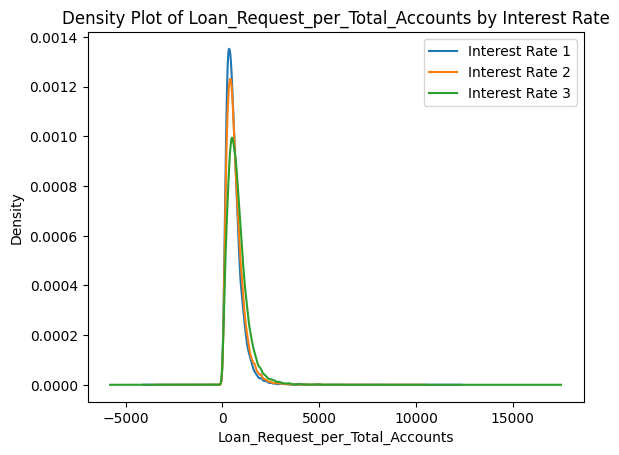

In [54]:
numerical_features_with_target(df, 'Loan_Request_per_Total_Accounts')

In [55]:
df['Inquiry_Intensity'] = df['Inquiries_Last_6Mo'] / (df['Number_Open_Accounts'])

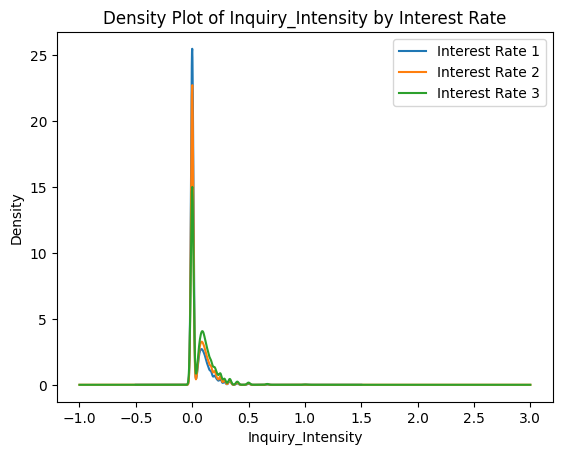

In [56]:
numerical_features_with_target(df, 'Inquiry_Intensity')

In [57]:
df['Loan_Burden_Ratio'] = df['Loan_Amount_Requested'] / (df['Annual_Income'] / 12)

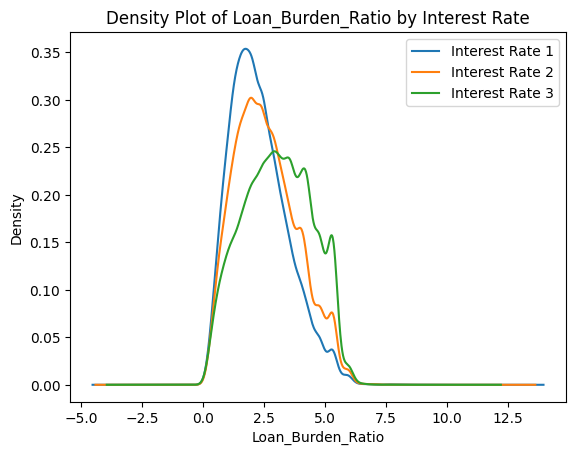

In [58]:
numerical_features_with_target(df, 'Loan_Burden_Ratio')

In [59]:
df['Income_Per_Account'] = df['Annual_Income'] / (df['Total_Accounts'])

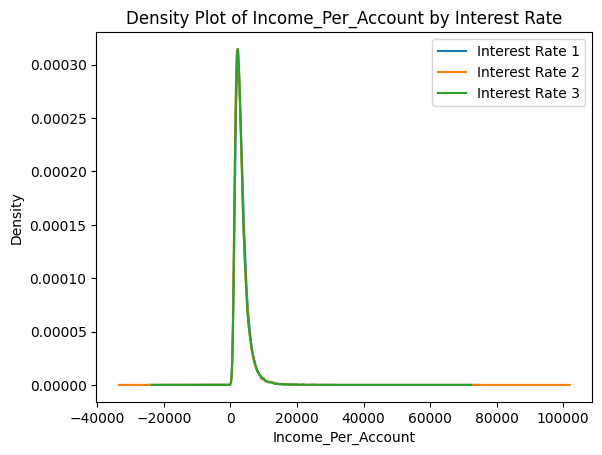

In [60]:
numerical_features_with_target(df, 'Income_Per_Account')

In [61]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 96816 entries, 0 to 164303
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Loan_Amount_Requested            96816 non-null  float64
 1   Length_Employed                  96816 non-null  float64
 2   Home_Owner                       96816 non-null  object 
 3   Annual_Income                    96816 non-null  float64
 4   Income_Verified                  96816 non-null  object 
 5   Purpose_Of_Loan                  96816 non-null  object 
 6   Debt_To_Income                   96816 non-null  float64
 7   Inquiries_Last_6Mo               96816 non-null  int64  
 8   Months_Since_Deliquency          96816 non-null  float64
 9   Number_Open_Accounts             96816 non-null  int64  
 10  Total_Accounts                   96816 non-null  int64  
 11  Gender                           96816 non-null  object 
 12  Interest_Rate         

In [62]:
df_cleaned = df.drop(['Home_Owner', 'Income_Verified', 'Purpose_Of_Loan'], axis=1).reset_index(drop=True)
df_cleaned.head()

,Loan_Amount_Requested,Length_Employed,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate,Simplified_Purpose,Is_Home_Owner,Is_Income_Verified,Debt_To_Income_per_Account,Income_to_Loan_Ratio,Credit_Utilization,Loan_Request_per_Total_Accounts,Inquiry_Intensity,Loan_Burden_Ratio,Income_Per_Account
0,7000.0,0.0,68000.0,18.37,0,999.0,9,14,Female,1,Personal,0,0,2.041111,9.714286,0.642857,500.000000,0.000000,1.235294,4857.142857
1,24725.0,7.0,75566.4,15.88,0,999.0,12,16,Male,3,Debt,1,0,1.323333,3.056275,0.750000,1545.312500,0.000000,3.926348,4722.900000
2,17000.0,8.0,96000.0,22.17,1,999.0,19,30,Female,1,Debt,1,0,1.166842,5.647059,0.633333,566.666667,0.052632,2.125000,3200.000000
3,4500.0,2.0,30000.0,10.88,1,999.0,12,15,Male,3,Debt,0,0,0.906667,6.666667,0.800000,300.000000,0.083333,1.800000,2000.000000
4,18075.0,4.0,85000.0,5.65,0,999.0,9,12,Male,3,Debt,0,1,0.627778,4.702628,0.750000,1506.250000,0.000000,2.551765,7083.333333


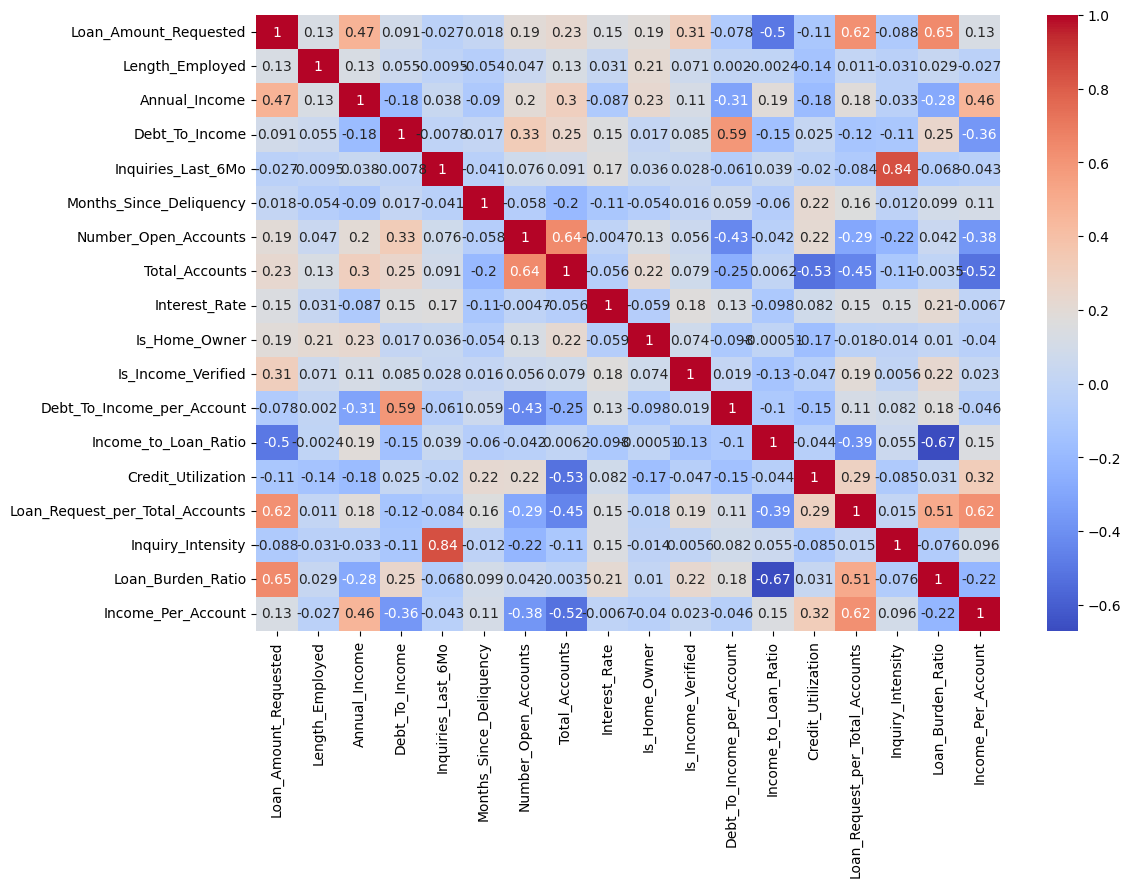

In [63]:
# Select only numeric columns
numeric_df = df_cleaned.select_dtypes(include=['number'])

# Create a heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2g', cmap='coolwarm')

plt.show()

**EDA Conclusion**

The EDA conclusion based on the countplot and density plot shows that the data distribution between class 2 and class 3 is quite similar. Both classes exhibit almost identical patterns, which suggests that the model may face challenges distinguishing between these two classes effectively. This could make the modeling process difficult, as the model might struggle to differentiate the classes with high accuracy. To address this issue, additional approaches such as class balancing, feature engineering techniques, or choosing a model more capable of handling overlapping classes might be necessary.

### Modeling Preparations

In [64]:
# Converting categorical features to numeric
transformer = ColumnTransformer([
    ('One Hot', OneHotEncoder(drop='first'), ['Gender', 'Simplified_Purpose'])], remainder='passthrough')

In [65]:
encoder = LabelEncoder()

In [66]:
# Separating independent variable data from the target
X = df_cleaned.drop(['Interest_Rate'], axis=1)
y = encoder.fit_transform(df_cleaned['Interest_Rate'])  # Target

In [67]:
# Splitting training and test data with a proportion of 80:20
X_train, X_test, y_train, y_test= train_test_split(
    X,
    y,  
    test_size=0.2,
    random_state=42)

In [68]:
scaler = StandardScaler() 

## Machine Learning Modeling

### Model Benchmarking : K-Fold

In [69]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier(verbose=-1)
gnb = GaussianNB()
gbc = GradientBoostingClassifier()
abc = AdaBoostClassifier()
xgbrf = XGBRFClassifier()
catboost = CatBoostClassifier(verbose=0)

In [70]:
models = [logreg, knn, dt, rf, xgb, lgbm, gnb, gbc, abc, xgbrf, catboost]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('scaler', scaler),
        ('model',i)])
    model_cv=cross_val_score(estimator,X_train,y_train,cv=skfold,n_jobs=-1,scoring='accuracy')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM',
                      'GaussianNB', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'XGBRFClassifier', 'CatBoostClassifier'
                      ],'mean acc':rata,'sdev':std}).set_index('model').sort_values(by='mean acc',ascending=False)

,mean acc,sdev
model,,
LightGBM,0.531039,0.002108
CatBoostClassifier,0.528508,0.001507
GradientBoostingClassifier,0.528314,0.001739
XGBoost,0.527720,0.003142
AdaBoostClassifier,0.522814,0.003262
Logistic Regression,0.520748,0.000596
XGBRFClassifier,0.514732,0.001705
Random Forest,0.508573,0.001150
GaussianNB,0.480155,0.003828


## Model Benchmarking : Test Data

In [71]:
models = [logreg, knn, dt, rf, xgb, lgbm, gnb, gbc, abc, xgbrf, catboost]
score_accuracy = []

def y_pred_func(i):
    # Create a pipeline with preprocessing and models
    estimator = Pipeline([
        ('preprocess', transformer),
        ('scaler', scaler),
        ('model', i)
    ])
    
    # Training the model
    estimator.fit(X_train, y_train)
    # Make predictions on test data
    y_pred = estimator.predict(X_test)
    
    return estimator, y_pred

# Loop to evaluate each model
for i, model_name in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest','XGBoost', 'LightGBM',
                                  'GaussianNB', 'Gradient Boosting','AdaBoost', 'XGBRF', 'CatBoost']):
    estimator, y_pred = y_pred_func(i)
    # Calculating accuracy
    accuracy = accuracy_score(y_test, y_pred)
    score_accuracy.append(accuracy)
    print(f"{model_name}:\n{classification_report(y_test, y_pred)}")

# Create a DataFrame to display the accuracy results of each model
pd.DataFrame({
    'model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest','XGBoost', 'LightGBM',
              'GaussianNB', 'Gradient Boosting','AdaBoost', 'XGBRF', 'CatBoost'],
    'accuracy': score_accuracy
}).set_index('model').sort_values(by='accuracy', ascending=False)

Logistic Regression:
              precision    recall  f1-score   support

           0       0.53      0.22      0.31      4125
           1       0.49      0.69      0.57      8490
           2       0.56      0.49      0.52      6749

    accuracy                           0.52     19364
   macro avg       0.53      0.47      0.47     19364
weighted avg       0.53      0.52      0.50     19364

KNN:
              precision    recall  f1-score   support

           0       0.33      0.37      0.35      4125
           1       0.46      0.52      0.49      8490
           2       0.51      0.40      0.45      6749

    accuracy                           0.45     19364
   macro avg       0.44      0.43      0.43     19364
weighted avg       0.45      0.45      0.45     19364

Decision Tree:
              precision    recall  f1-score   support

           0       0.31      0.31      0.31      4125
           1       0.45      0.45      0.45      8490
           2       0.43      0.44 

,accuracy
model,
CatBoost,0.523446
LightGBM,0.523032
XGBoost,0.522774
Gradient Boosting,0.522206
Logistic Regression,0.518643
AdaBoost,0.516990
XGBRF,0.511310
Random Forest,0.500878
GaussianNB,0.480273


From benchmarking several algorithms using k-fold cross-validation and test data, it is evident that LightGBM outperforms the others with an accuracy of 53%. Therefore, the model development will proceed with LightGBM, as it provides the best performance in terms of accuracy and efficiency.

In [72]:
# Define the standard pipeline
pipeline_standard = Pipeline([
    ('preprocess', transformer),  # Preprocessing step (e.g., OneHotEncoding, etc.)
    ('scaler', scaler),  # Scaling step (e.g., StandardScaler)
    ('model', lgbm)  # LightGBM classifier
])

## Smote

In [73]:
# Define the pipeline with SMOTE
pipeline_with_smote = Pipeline([
    ('preprocess', transformer),  # Preprocessing step (e.g., OneHotEncoding, etc.)
    ('scaler', scaler),  # Scaling step (e.g., StandardScaler)
    ('smote', SMOTE(sampling_strategy='auto')),  # SMOTE for oversampling imbalanced classes
    ('model', lgbm)  # LightGBM classifier
])

# Perform cross-validation for the pipeline with SMOTE
cv_scores_smote = cross_val_score(pipeline_with_smote, X_train, y_train, cv=5, scoring='accuracy')

# Perform cross-validation for the pipeline without SMOTE
cv_scores_no_smote = cross_val_score(pipeline_standard, X_train, y_train, cv=5, scoring='accuracy')

# Display cross-validation results
print(f"Cross-validation scores with SMOTE: {cv_scores_smote}")
print(f"Mean accuracy with SMOTE: {cv_scores_smote.mean():.4f}")

print(f"Cross-validation scores without SMOTE: {cv_scores_no_smote}")
print(f"Mean accuracy without SMOTE: {cv_scores_no_smote.mean():.4f}")

# Conclusion
if cv_scores_smote.mean() > cv_scores_no_smote.mean():
    print("SMOTE improves model performance, so it should be used.")
else:
    print("SMOTE does not improve performance or is unnecessary.")

Cross-validation scores with SMOTE: [0.52301336 0.52701569 0.52143318 0.52601679 0.52440284]
Mean accuracy with SMOTE: 0.5244
Cross-validation scores without SMOTE: [0.5281131  0.53424569 0.53085862 0.53227889 0.52969658]
Mean accuracy without SMOTE: 0.5310
SMOTE does not improve performance or is unnecessary.


## Feature Selection: RFE

The following step is to select the features with RFE

In [74]:
# List of features to select using RFE
n_features_list = [5, 10, 15]


# Cross-validation for model without RFE
cv_scores_no_rfe = cross_val_score(pipeline_standard, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores without RFE: {cv_scores_no_rfe}")
print(f"Mean accuracy without RFE: {cv_scores_no_rfe.mean():.4f}")
print('=======================')

# Store the mean scores for each RFE configuration
rfe_scores = {}

# Loop through each value in n_features_list
for n_features in n_features_list:
    print(f"\nSelecting top {n_features} features with RFE:")

    # Define pipeline with RFE
    pipeline_with_rfe = Pipeline([
        ('preprocess', transformer),
        ('scaler', scaler),
        ('rfe', RFE(estimator=lgbm, n_features_to_select=n_features)),  # Select n features
        ('model', lgbm)
    ])

    # Cross-validation for model with RFE
    cv_scores_rfe = cross_val_score(pipeline_with_rfe, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation scores with top {n_features} features: {cv_scores_rfe}")
    print(f"Mean accuracy with top {n_features} features: {cv_scores_rfe.mean():.4f}")

    # Store the mean score for comparison
    rfe_scores[n_features] = cv_scores_rfe.mean()

    # Fit the pipeline to training data for feature selection
    pipeline_with_rfe.fit(X_train, y_train)
    
    # Get feature names after OneHotEncoder transformation
    feature_names = (
        pipeline_with_rfe.named_steps['preprocess']
        .transformers_[0][1]
        .get_feature_names_out(['Gender', 'Simplified_Purpose'])
    )
    # Add non-categorical features (remainder)
    feature_names = list(feature_names) + list(X_train.columns.difference(['Gender', 'Simplified_Purpose']))
    
    # Display features selected by RFE
    selected_features = [feature_names[i] for i, selected in enumerate(pipeline_with_rfe.named_steps['rfe'].support_) if selected]
    print(f"Features selected by RFE: {selected_features}")
    print('=======================')

# Find which model (with or without RFE) performed the best
mean_no_rfe = cv_scores_no_rfe.mean()

# Find the best RFE model
best_rfe_model = max(rfe_scores, key=rfe_scores.get)

# Compare mean accuracy values
if mean_no_rfe > rfe_scores[best_rfe_model]:
    print("Model without RFE is the best performing model.")
else:
    print(f"RFE with {best_rfe_model} features performed best.")


Cross-validation scores without RFE: [0.5281131  0.53424569 0.53085862 0.53227889 0.52969658]
Mean accuracy without RFE: 0.5310

Selecting top 5 features with RFE:
Cross-validation scores with top 5 features: [0.49241495 0.49422245 0.49089735 0.48921885 0.48870239]
Mean accuracy with top 5 features: 0.4911
Features selected by RFE: ['Annual_Income', 'Debt_To_Income_per_Account', 'Length_Employed', 'Loan_Amount_Requested', 'Loan_Burden_Ratio']

Selecting top 10 features with RFE:
Cross-validation scores with top 10 features: [0.51249112 0.51339487 0.51316979 0.51581666 0.51768883]
Mean accuracy with top 10 features: 0.5145
Features selected by RFE: ['Annual_Income', 'Debt_To_Income', 'Debt_To_Income_per_Account', 'Income_to_Loan_Ratio', 'Length_Employed', 'Loan_Amount_Requested', 'Loan_Burden_Ratio', 'Loan_Request_per_Total_Accounts', 'Months_Since_Deliquency', 'Total_Accounts']

Selecting top 15 features with RFE:
Cross-validation scores with top 15 features: [0.51830095 0.51662256 0.5

## PCA

In [75]:
from sklearn.decomposition import PCA

# Preparing PCA to retain 95% of the variance
pca = PCA(n_components=0.95)


# Define the pipeline with PCA
pipeline_with_pca = Pipeline([
    ('preprocess', transformer),  # Preprocessing step (e.g., OneHotEncoding, etc.)
    ('scaler', StandardScaler()),  # Scaling the data
    ('pca', pca),  # Apply PCA to reduce dimensionality
    ('model', lgbm)  # LightGBM model
])

# Perform cross-validation for pipeline without PCA
cv_scores_without_pca = cross_val_score(pipeline_standard, X_train, y_train, cv=skfold, scoring='accuracy')

# Perform cross-validation for pipeline with PCA
cv_scores_with_pca = cross_val_score(pipeline_with_pca, X_train, y_train, cv=skfold, scoring='accuracy')

# Display the results
print("LightGBM without PCA Cross-Validation Results:")
print(f"Mean Accuracy: {cv_scores_without_pca.mean():.4f}")
print(f"Standard Deviation: {cv_scores_without_pca.std():.4f}")
print('=======================')

print("LightGBM with PCA Cross-Validation Results:")
print(f"Mean Accuracy: {cv_scores_with_pca.mean():.4f}")
print(f"Standard Deviation: {cv_scores_with_pca.std():.4f}")
print('=======================')

# Conclusion
if cv_scores_with_pca.mean() > cv_scores_without_pca.mean():
    print("Using PCA improves the model performance.")
else:
    print("PCA does not improve the model performance or may reduce it.")

LightGBM without PCA Cross-Validation Results:
Mean Accuracy: 0.5310
Standard Deviation: 0.0021
LightGBM with PCA Cross-Validation Results:
Mean Accuracy: 0.5208
Standard Deviation: 0.0016
PCA does not improve the model performance or may reduce it.


After applying Principal Component Analysis (PCA) with the goal of retaining 95% of the variance, the model's accuracy has decreased compared to the standard model that used all features.

Since PCA didn’t improve the model's performance, the next step is to hyperpamaeter tuning

## Hyperparameter Tuning

In [76]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter search space
param_dist = {
    'model__num_leaves': [31, 50, 70, 90, 120],  # Number of leaves in each tree
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate
    'model__n_estimators': [50, 100, 150, 200],  # Number of trees
    'model__max_depth': [5, 10, 15, 20],  # Maximum depth of trees
    'model__subsample': [0.8, 0.9, 1.0],  # Fraction of samples used per tree
    'model__colsample_bytree': [0.8, 0.9, 1.0]  # Fraction of features used per tree
}

# Set up StratifiedKFold cross-validation (for stratified sampling)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the pipeline with hyperparameter tuning using RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline_standard,  # Pipeline with SMOTE and scaling
    param_distributions=param_dist,  # Hyperparameter distribution
    n_iter=10,  # Number of random configurations to try
    cv=skfold,  # 5-fold cross-validation with StratifiedKFold
    scoring='accuracy',  # Scoring metric
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,  # For reproducibility
    verbose=1  # Display progress
)

# Fit random search with cross-validation
random_search.fit(X_train, y_train)

# Get the best model from random search
best_model = random_search.best_estimator_

# Print the best parameters from the random search
print("Best Hyperparameters from Randomized Search:")
print(random_search.best_params_)

# Evaluate the standard model (without hyperparameter tuning)
pipeline_standard.fit(X_train, y_train)
y_pred_standard = pipeline_standard.predict(X_test)
accuracy_standard = accuracy_score(y_test, y_pred_standard)

# Evaluate the best model (with hyperparameter tuning)
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)

# Compare the results
print(f"\nAccuracy of Standard Pipeline: {accuracy_standard:.4f}")
print(f"Accuracy of Best Model from Randomized Search: {accuracy_best:.4f}")

if accuracy_best > accuracy_standard:
    print("\nThe Best Model from Randomized Search performs better than the Standard Pipeline.")
else:
    print("\nThe Standard Pipeline performs better or equally as the Best Model.")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters from Randomized Search:
{'model__subsample': 0.9, 'model__num_leaves': 50, 'model__n_estimators': 150, 'model__max_depth': 10, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.9}

Accuracy of Standard Pipeline: 0.5230
Accuracy of Best Model from Randomized Search: 0.5242

The Best Model from Randomized Search performs better than the Standard Pipeline.


In [77]:
# Output the classification reports for both models
print("\nClassification Report for Standard Pipeline:")
print(classification_report(y_test, y_pred_standard))

print("\nClassification Report for Best Model from Randomized Search:")
print(classification_report(y_test, y_pred_best))


Classification Report for Standard Pipeline:
              precision    recall  f1-score   support

           0       0.52      0.24      0.33      4125
           1       0.50      0.66      0.57      8490
           2       0.57      0.52      0.55      6749

    accuracy                           0.52     19364
   macro avg       0.53      0.48      0.48     19364
weighted avg       0.53      0.52      0.51     19364


Classification Report for Best Model from Randomized Search:
              precision    recall  f1-score   support

           0       0.52      0.24      0.33      4125
           1       0.50      0.66      0.57      8490
           2       0.57      0.52      0.55      6749

    accuracy                           0.52     19364
   macro avg       0.53      0.48      0.48     19364
weighted avg       0.53      0.52      0.51     19364



Final conclusion based on the machine learning model:

The benchmarking results indicate that LightGBM outperforms the other models, achieving the highest accuracy at only 53%. Techniques like SMOTE, RFE, and PCA did not contribute positively to the model's performance, as they did not lead to significant improvements. Hyperparameter tuning also showed minimal impact on the accuracy, with the improvement being nearly negligible. Despite LightGBM being the top performer, the overall model accuracy remains low, suggesting that further refinement or different approaches may be needed to improve performance.

# Deep Learning Model

Several Deep Learning model to use:

1. Feedforward Neural Network (FNN)
    - Why is it chosen? FNN is a simple yet effective neural network model for tabular data. Tabular data is data organized in a table (e.g., customer data with columns like age, income, and job status). FNN works well because it does not assume any time-based or sequential patterns, which are often found in image or time-series data. FNN can directly learn the relationships between features in the tabular data and the target output.
2. Deep Neural Network (DNN)
    - Why is it chosen? DNN is a deeper version of FNN, meaning it has more hidden layers. DNN allows the model to learn more complex and intricate patterns in the data. For tabular data, if the relationships between features are highly complex and not easily understood, DNN can help capture these patterns better.
3. Convolutional Neural Network (CNN)
    - Why is it chosen? CNN is primarily known for image processing, as it can recognize local patterns like lines or shapes in images. However, recent studies have shown that CNN can also be useful for tabular data, especially when recognizing local patterns or relationships between certain groups or sequences of features. For example, if your tabular data has hidden patterns in combinations of features, CNN might help discover these patterns.

In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization #FNN
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization #CNN
from tensorflow.keras.layers import Dense, Dropout #DNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [79]:
# Re-Define X and y
X = df_cleaned.drop(['Interest_Rate'], axis=1)
y = encoder.fit_transform(df_cleaned['Interest_Rate'])  # Encoding target variable

# Preprocessing pipeline
pipeline = Pipeline(steps=[('preprocess', transformer),
                           ('scaler', scaler)
                          ])

# Apply preprocessing
X_transformed = pipeline.fit_transform(X)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_transformed, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert target to one-hot encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

## Feedforward Neural Network (FNN)

Epoch 1/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.4523 - loss: 1.1116 - val_accuracy: 0.5112 - val_loss: 0.9618
Epoch 2/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5064 - loss: 0.9729 - val_accuracy: 0.5149 - val_loss: 0.9572
Epoch 3/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5154 - loss: 0.9636 - val_accuracy: 0.5158 - val_loss: 0.9559
Epoch 4/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5100 - loss: 0.9666 - val_accuracy: 0.5163 - val_loss: 0.9554
Epoch 5/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5154 - loss: 0.9635 - val_accuracy: 0.5196 - val_loss: 0.9532
Epoch 6/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5171 - loss: 0.9595 - val_accuracy: 0.5166 - val_loss: 0.9537
Epoch 7/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5151 - loss: 0.9593 - val_accuracy: 0.5164 - val_loss: 0.9548
Epoch 8/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5158 -

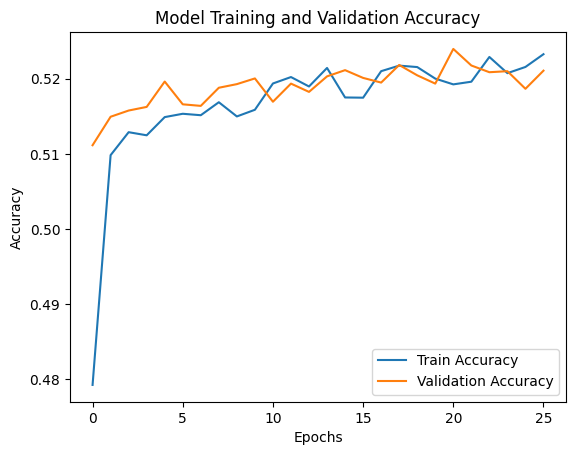

In [80]:
# Define deep learning model
model = Sequential()

# Input layer
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Hidden layer 1
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Hidden layer 2
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output layer
model.add(Dense(y_train.shape[1], activation='softmax'))  # Multi-class classification

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopping])

# Evaluate model performance on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Training and Validation Accuracy')
plt.show()


## Convolutional Neural Network (CNN)

Epoch 1/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 26s 11ms/step - accuracy: 0.4552 - loss: 1.1226 - val_accuracy: 0.5138 - val_loss: 0.9645
Epoch 2/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.5062 - loss: 0.9763 - val_accuracy: 0.5148 - val_loss: 0.9599
Epoch 3/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.5103 - loss: 0.9675 - val_accuracy: 0.5150 - val_loss: 0.9615
Epoch 4/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.5112 - loss: 0.9702 - val_accuracy: 0.5148 - val_loss: 0.9607
Epoch 5/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.5099 - loss: 0.9708 - val_accuracy: 0.5165 - val_loss: 0.9570
Epoch 6/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.5133 - loss: 0.9666 - val_accuracy: 0.5170 - val_loss: 0.9578
Epoch 7/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5123 - loss: 0.9657 - val_accuracy: 0.5200 - val_loss: 0.9569
Epoch 8/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.

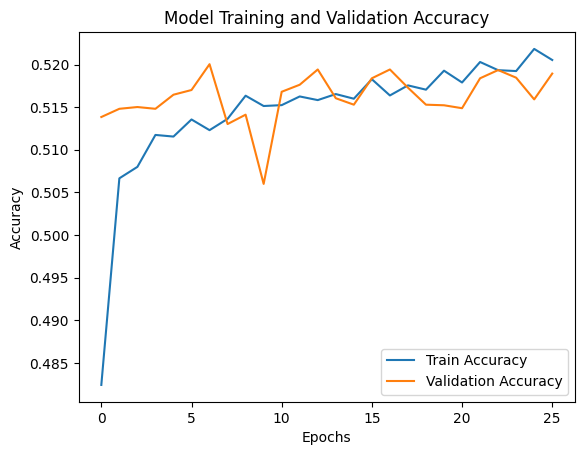

In [81]:
# Define CNN model
model = Sequential()

# Convolutional Layer 1
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Convolutional Layer 2
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Flatten the output for dense layers
model.add(Flatten())

# Fully Connected Layer 1
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(y_train.shape[1], activation='softmax'))  # Multi-class classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopping])

# Evaluate model performance on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Training and Validation Accuracy')
plt.show()


## Deep Neural Network (DNN)

Epoch 1/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.4562 - loss: 1.0363 - val_accuracy: 0.5096 - val_loss: 0.9682
Epoch 2/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.4987 - loss: 0.9843 - val_accuracy: 0.5066 - val_loss: 0.9666
Epoch 3/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.5098 - loss: 0.9723 - val_accuracy: 0.5135 - val_loss: 0.9627
Epoch 4/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.5102 - loss: 0.9713 - val_accuracy: 0.5096 - val_loss: 0.9664
Epoch 5/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.5140 - loss: 0.9678 - val_accuracy: 0.5173 - val_loss: 0.9613
Epoch 6/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.5143 - loss: 0.9670 - val_accuracy: 0.5161 - val_loss: 0.9620
Epoch 7/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.5107 - loss: 0.9683 - val_accuracy: 0.5176 - val_loss: 0.9590
Epoch 8/100
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.5130 -

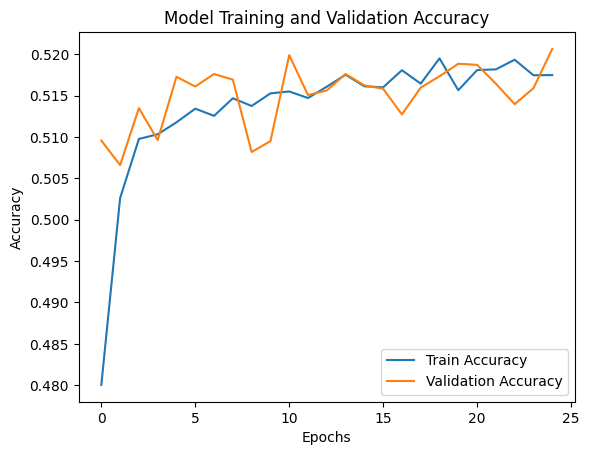

In [82]:
# Define DNN model with more layers and neurons
model = Sequential()

# Input layer
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))

# Hidden layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopping])

# Evaluate model performance on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Training and Validation Accuracy')
plt.show()

After testing three types of deep learning models—CNN, FNN, and DNN—it was found that none of them surpassed the accuracy of LightGBM. Therefore, it can be concluded that the model will consistently have low accuracy. This outcome is likely aligned with the earlier EDA results, which showed that classes 2 and 3 have very similar characteristics. This similarity between the classes poses a challenge for model performance, as distinguishing between them remains difficult.

### Re-Model with 2 Classes

In [85]:
df_copy=df_cleaned.copy()
df_copy['Interest_Rate'].replace(3, 2, inplace=True)

In [86]:
# Separating independent variable data from the target
X = df_copy.drop(['Interest_Rate'], axis=1)
y = encoder.fit_transform(df_copy['Interest_Rate'])  # Target

In [88]:
# Splitting training and test data with a proportion of 80:20
X_train, X_test, y_train, y_test= train_test_split(
    X,
    y,  
    test_size=0.2,
    random_state=42)

In [92]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier(verbose=-1)
gnb = GaussianNB()
gbc = GradientBoostingClassifier()
abc = AdaBoostClassifier()
xgbrf = XGBRFClassifier()
catboost = CatBoostClassifier(verbose=0)

In [93]:
models = [logreg, knn, dt, rf, xgb, lgbm, gnb, gbc, abc, xgbrf, catboost]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('scaler', scaler),
        ('model',i)])
    model_cv=cross_val_score(estimator,X_train,y_train,cv=skfold,n_jobs=-1,scoring='accuracy')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM',
                      'GaussianNB', 'GradientBoostingClassifier', 'AdaBoostClassifier', 'XGBRFClassifier', 'CatBoostClassifier'
                      ],'mean acc':rata,'sdev':std}).set_index('model').sort_values(by='mean acc',ascending=False)

,mean acc,sdev
model,,
LightGBM,0.800005,0.001057
CatBoostClassifier,0.799876,0.000876
GradientBoostingClassifier,0.799605,0.001547
Logistic Regression,0.799179,0.001181
AdaBoostClassifier,0.798869,0.001266
Random Forest,0.796687,0.002177
XGBoost,0.795912,0.001296
XGBRFClassifier,0.794634,0.001583
KNN,0.770025,0.001026


## SMOTE

In [94]:
models = [logreg, knn, dt, rf, xgb, lgbm, gnb, gbc, abc, xgbrf, catboost]
score_accuracy = []

def y_pred_func(i):
    # Create a pipeline with preprocessing and models
    estimator = Pipeline([
        ('preprocess', transformer),
        ('scaler', scaler),
        ('model', i)
    ])
    
    # Training the model
    estimator.fit(X_train, y_train)
    # Make predictions on test data
    y_pred = estimator.predict(X_test)
    
    return estimator, y_pred

# Loop to evaluate each model
for i, model_name in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest','XGBoost', 'LightGBM',
                                  'GaussianNB', 'Gradient Boosting','AdaBoost', 'XGBRF', 'CatBoost']):
    estimator, y_pred = y_pred_func(i)
    # Calculating accuracy
    accuracy = accuracy_score(y_test, y_pred)
    score_accuracy.append(accuracy)
    print(f"{model_name}:\n{classification_report(y_test, y_pred)}")

# Create a DataFrame to display the accuracy results of each model
pd.DataFrame({
    'model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest','XGBoost', 'LightGBM',
              'GaussianNB', 'Gradient Boosting','AdaBoost', 'XGBRF', 'CatBoost'],
    'accuracy': score_accuracy
}).set_index('model').sort_values(by='accuracy', ascending=False)

Logistic Regression:
              precision    recall  f1-score   support

           0       0.60      0.13      0.21      4125
           1       0.81      0.98      0.88     15239

    accuracy                           0.80     19364
   macro avg       0.70      0.55      0.55     19364
weighted avg       0.76      0.80      0.74     19364

KNN:
              precision    recall  f1-score   support

           0       0.40      0.22      0.28      4125
           1       0.81      0.91      0.86     15239

    accuracy                           0.76     19364
   macro avg       0.60      0.57      0.57     19364
weighted avg       0.72      0.76      0.74     19364

Decision Tree:
              precision    recall  f1-score   support

           0       0.30      0.33      0.31      4125
           1       0.81      0.80      0.80     15239

    accuracy                           0.70     19364
   macro avg       0.56      0.56      0.56     19364
weighted avg       0.70      0.70

,accuracy
model,
Gradient Boosting,0.797666
LightGBM,0.796788
AdaBoost,0.796478
Logistic Regression,0.796426
CatBoost,0.795032
XGBoost,0.793844
Random Forest,0.790952
XGBRF,0.790849
KNN,0.762807


As the result of the step, remodeling was conducted by reducing the number of classes to two. After this change, the model's accuracy significantly increased to 79%. This improvement indicates that by reducing the number of highly similar classes, the model can better focus on distinguishing key patterns in the data.

In [95]:
# Define the pipeline with SMOTE
pipeline_with_smote = Pipeline([
    ('preprocess', transformer),  # Preprocessing step (e.g., OneHotEncoding, etc.)
    ('scaler', scaler),  # Scaling step (e.g., StandardScaler)
    ('smote', SMOTE(sampling_strategy='auto')),  # SMOTE for oversampling imbalanced classes
    ('model', lgbm)  # LightGBM classifier
])

# Perform cross-validation for the pipeline with SMOTE
cv_scores_smote = cross_val_score(pipeline_with_smote, X_train, y_train, cv=5, scoring='accuracy')

# Perform cross-validation for the pipeline without SMOTE
cv_scores_no_smote = cross_val_score(pipeline_standard, X_train, y_train, cv=5, scoring='accuracy')

# Display cross-validation results
print(f"Cross-validation scores with SMOTE: {cv_scores_smote}")
print(f"Mean accuracy with SMOTE: {cv_scores_smote.mean():.4f}")

print(f"Cross-validation scores without SMOTE: {cv_scores_no_smote}")
print(f"Mean accuracy without SMOTE: {cv_scores_no_smote.mean():.4f}")

# Conclusion
if cv_scores_smote.mean() > cv_scores_no_smote.mean():
    print("SMOTE improves model performance, so it should be used.")
else:
    print("SMOTE does not improve performance or is unnecessary.")

Cross-validation scores with SMOTE: [0.79336389 0.78955523 0.79122014 0.79257586 0.7883796 ]
Mean accuracy with SMOTE: 0.7910
Cross-validation scores without SMOTE: [0.80162675 0.79917371 0.7995481  0.80083925 0.79883796]
Mean accuracy without SMOTE: 0.8000
SMOTE does not improve performance or is unnecessary.


## Feature Selection: RFE

In [96]:
# List of features to select using RFE
n_features_list = [5, 10, 15]


# Cross-validation for model without RFE
cv_scores_no_rfe = cross_val_score(pipeline_standard, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores without RFE: {cv_scores_no_rfe}")
print(f"Mean accuracy without RFE: {cv_scores_no_rfe.mean():.4f}")
print('=======================')

# Store the mean scores for each RFE configuration
rfe_scores = {}

# Loop through each value in n_features_list
for n_features in n_features_list:
    print(f"\nSelecting top {n_features} features with RFE:")

    # Define pipeline with RFE
    pipeline_with_rfe = Pipeline([
        ('preprocess', transformer),
        ('scaler', scaler),
        ('rfe', RFE(estimator=lgbm, n_features_to_select=n_features)),  # Select n features
        ('model', lgbm)
    ])

    # Cross-validation for model with RFE
    cv_scores_rfe = cross_val_score(pipeline_with_rfe, X_train, y_train, cv=5, scoring='accuracy')
    print(f"Cross-validation scores with top {n_features} features: {cv_scores_rfe}")
    print(f"Mean accuracy with top {n_features} features: {cv_scores_rfe.mean():.4f}")

    # Store the mean score for comparison
    rfe_scores[n_features] = cv_scores_rfe.mean()

    # Fit the pipeline to training data for feature selection
    pipeline_with_rfe.fit(X_train, y_train)
    
    # Get feature names after OneHotEncoder transformation
    feature_names = (
        pipeline_with_rfe.named_steps['preprocess']
        .transformers_[0][1]
        .get_feature_names_out(['Gender', 'Simplified_Purpose'])
    )
    # Add non-categorical features (remainder)
    feature_names = list(feature_names) + list(X_train.columns.difference(['Gender', 'Simplified_Purpose']))
    
    # Display features selected by RFE
    selected_features = [feature_names[i] for i, selected in enumerate(pipeline_with_rfe.named_steps['rfe'].support_) if selected]
    print(f"Features selected by RFE: {selected_features}")
    print('=======================')

# Find which model (with or without RFE) performed the best
mean_no_rfe = cv_scores_no_rfe.mean()

# Find the best RFE model
best_rfe_model = max(rfe_scores, key=rfe_scores.get)

# Compare mean accuracy values
if mean_no_rfe > rfe_scores[best_rfe_model]:
    print("Model without RFE is the best performing model.")
else:
    print(f"RFE with {best_rfe_model} features performed best.")


Cross-validation scores without RFE: [0.80162675 0.79917371 0.7995481  0.80083925 0.79883796]
Mean accuracy without RFE: 0.8000

Selecting top 5 features with RFE:
Cross-validation scores with top 5 features: [0.78878058 0.7890388  0.78986443 0.78921885 0.78876695]
Mean accuracy with top 5 features: 0.7891
Features selected by RFE: ['Annual_Income', 'Debt_To_Income_per_Account', 'Length_Employed', 'Loan_Amount_Requested', 'Loan_Burden_Ratio']

Selecting top 10 features with RFE:
Cross-validation scores with top 10 features: [0.79788264 0.7954296  0.7954164  0.79728857 0.79599742]
Mean accuracy with top 10 features: 0.7964
Features selected by RFE: ['Annual_Income', 'Debt_To_Income', 'Debt_To_Income_per_Account', 'Income_to_Loan_Ratio', 'Length_Employed', 'Loan_Amount_Requested', 'Loan_Burden_Ratio', 'Loan_Request_per_Total_Accounts', 'Months_Since_Deliquency', 'Total_Accounts']

Selecting top 15 features with RFE:
Cross-validation scores with top 15 features: [0.79981925 0.79820541 0.7

## PCA

In [97]:
from sklearn.decomposition import PCA

# Preparing PCA to retain 95% of the variance
pca = PCA(n_components=0.95)


# Define the pipeline with PCA
pipeline_with_pca = Pipeline([
    ('preprocess', transformer),  # Preprocessing step (e.g., OneHotEncoding, etc.)
    ('scaler', StandardScaler()),  # Scaling the data
    ('pca', pca),  # Apply PCA to reduce dimensionality
    ('model', lgbm)  # LightGBM model
])

# Perform cross-validation for pipeline without PCA
cv_scores_without_pca = cross_val_score(pipeline_standard, X_train, y_train, cv=skfold, scoring='accuracy')

# Perform cross-validation for pipeline with PCA
cv_scores_with_pca = cross_val_score(pipeline_with_pca, X_train, y_train, cv=skfold, scoring='accuracy')

# Display the results
print("LightGBM without PCA Cross-Validation Results:")
print(f"Mean Accuracy: {cv_scores_without_pca.mean():.4f}")
print(f"Standard Deviation: {cv_scores_without_pca.std():.4f}")
print('=======================')

print("LightGBM with PCA Cross-Validation Results:")
print(f"Mean Accuracy: {cv_scores_with_pca.mean():.4f}")
print(f"Standard Deviation: {cv_scores_with_pca.std():.4f}")
print('=======================')

# Conclusion
if cv_scores_with_pca.mean() > cv_scores_without_pca.mean():
    print("Using PCA improves the model performance.")
else:
    print("PCA does not improve the model performance or may reduce it.")

LightGBM without PCA Cross-Validation Results:
Mean Accuracy: 0.8000
Standard Deviation: 0.0011
LightGBM with PCA Cross-Validation Results:
Mean Accuracy: 0.7983
Standard Deviation: 0.0018
PCA does not improve the model performance or may reduce it.


Since PCA didn’t improve the model's performance, the next step is to hyperpamaeter tuning

## Hyperpamaeter Tuning

In [99]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter search space
param_dist = {
    'model__num_leaves': [31, 50, 70, 90, 120],  # Number of leaves in each tree
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate
    'model__n_estimators': [50, 100, 150, 200],  # Number of trees
    'model__max_depth': [5, 10, 15, 20],  # Maximum depth of trees
    'model__subsample': [0.8, 0.9, 1.0],  # Fraction of samples used per tree
    'model__colsample_bytree': [0.8, 0.9, 1.0]  # Fraction of features used per tree
}

# Set up StratifiedKFold cross-validation (for stratified sampling)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the pipeline with hyperparameter tuning using RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline_standard,  # Pipeline with SMOTE and scaling
    param_distributions=param_dist,  # Hyperparameter distribution
    n_iter=10,  # Number of random configurations to try
    cv=skfold,  # 5-fold cross-validation with StratifiedKFold
    scoring='accuracy',  # Scoring metric
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,  # For reproducibility
    verbose=1  # Display progress
)

# Fit random search with cross-validation
random_search.fit(X_train, y_train)

# Get the best model from random search
best_model = random_search.best_estimator_

# Print the best parameters from the random search
print("Best Hyperparameters from Randomized Search:")
print(random_search.best_params_)

# Evaluate the standard model (without hyperparameter tuning)
pipeline_standard.fit(X_train, y_train)
y_pred_standard = pipeline_standard.predict(X_test)
accuracy_standard = accuracy_score(y_test, y_pred_standard)

# Evaluate the best model (with hyperparameter tuning)
y_pred_best = best_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)

# Compare the results
print(f"\nAccuracy of Standard Pipeline: {accuracy_standard:.4f}")
print(f"Accuracy of Best Model from Randomized Search: {accuracy_best:.4f}")

if accuracy_best > accuracy_standard:
    print("\nThe Best Model from Randomized Search performs better than the Standard Pipeline.")
else:
    print("\nThe Standard Pipeline performs better or equally as the Best Model.")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters from Randomized Search:
{'model__subsample': 0.9, 'model__num_leaves': 31, 'model__n_estimators': 200, 'model__max_depth': 20, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}

Accuracy of Standard Pipeline: 0.7968
Accuracy of Best Model from Randomized Search: 0.7975

The Best Model from Randomized Search performs better than the Standard Pipeline.


## Save Model

In [103]:
# Save Best Model
model_filename = "credit_interest.pkl"

with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best model has been saved as {model_filename}")

Best model has been saved as credit_interest.pkl
